In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import numpy as np
import seaborn as sns

import shap as shap  # Visualizing tool
from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error

from numpy import mean
from numpy import std
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor

In [5]:
%store -r train_features
%store -r test_features

%store -r train_labels
%store -r test_labels

# 6. LightGBM model

To define the input and output feature

Get the dataset


In [59]:
def get_dataset():
    #Y = kaggle_datasets_versions_users_data['TotalVotes']
    #X = kaggle_datasets_versions_users_data[
    #    ['Diff_LastActivityDate_CreationDate', 'Diff_LastActivityDate_Today','Description_Length', 'Bool_Description', 'Bool_Subtitle', 'TotalDownloads',
    # 'TotalViews']].copy()
    #X = X.sample(10000)
    #Y = Y.sample(10000)
    # print(X.shape, Y.shape)
    
    # train and test split
    # x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # return x_train, x_test, y_train, y_test
    
    return X, Y

## LightGBM Parameter Tuning

Get a list of models to evaluate

### Explore Number of Trees

In [283]:
def get_models_number_of_trees():
    models = dict()
    trees = [10, 50, 100, 500, 1000, 5000]
    for n in trees:
        models[str(n)] = LGBMRegressor(n_estimators=n)
    return models

Get a list of models to evaluate

### Explore Tree Depth

In [284]:
def get_models_tree_depth():
    models = dict()
    for i in range(1, 11):
        models[str(i)] = LGBMRegressor(max_depth=i, num_leaves=2 ** i)
    return models

Get a list of models to evaluate

### Explore learning rate

In [285]:
def get_models_learning_rate():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMRegressor(learning_rate=r)
    return models

## Explore Boosting Techniques

Explore lightgbm boosting type effect on performance

In [296]:
def get_models_boosting_techniques():
    models = dict()
    types = ['gbdt', 'dart', 'goss']
    for t in types:
        models[t] = LGBMRegressor(boosting_type=t)
    return models

Evaluate a give model using cross-validation

In [7]:
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, train_features, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')     
    return scores

## LGBM Fitting

Train and test split

In [10]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rate': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [11]:
# laoding data
lgb_train = lgb.Dataset(train_features, train_labels)
lgb_eval = lgb.Dataset(test_features, test_labels, reference=lgb_train)

In [12]:
# fitting the model
LGBMRegmodel = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Unknown parameter: learnnig_rate
[1]	valid_0's l2: 34571.1	valid_0's l1: 34.1016
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 28495.3	valid_0's l1: 31.3463
[3]	valid_0's l2: 23547.1	valid_0's l1: 28.9264
[4]	valid_0's l2: 19538.2	valid_0's l1: 26.9521
[5]	valid_0's l2: 16279.9	valid_0's l1: 25.2487
[6]	valid_0's l2: 13604	valid_0's l1: 23.6639
[7]	valid_0's l2: 11373.5	valid_0's l1: 22.3872
[8]	valid_0's l2: 9605.53	valid_0's l1: 21.2131
[9]	valid_0's l2: 8159.54	valid_0's l1: 19.4247
[10]	valid_0's l2: 6911.18	valid_0's l1: 18.5477
[11]	valid_0's l2: 5942.45	valid_0's l1: 17.6007
[12]	valid_0's l2: 5137.74	valid_0's l1: 16.2864
[13]	valid_0's l2: 4493.26	valid_0's l1: 15.1457
[14]	valid_0's l2: 3962.56	valid_0's l1: 14.1564
[15]	valid_0's l2: 3515.73	valid_0's l1: 13.3893
[16]	valid_0's l2: 3186.35	valid_0's l1: 12.6264
[17]	valid_0's l2: 2834.88	valid_0's l1: 12.2641
[18]	valid_0's l2: 2614.67	valid_0's l1: 11.6712
[19]	valid_0's

In [15]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(LGBMRegmodel, train_features, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

Report performance

In [16]:
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -3.109 (0.149)


Fit the model on the whole dataset

In [19]:
LGBMRegmodel.fit(train_features, train_labels, eval_set=[(test_features, test_labels), (train_features, train_labels)],
          verbose=20, eval_metric='mean_absolute_error')

[20]	training's l1: 7.48112	training's l2: 1980.75	valid_0's l1: 7.44264	valid_0's l2: 1156.27
[40]	training's l1: 4.01506	training's l2: 1049.99	valid_0's l1: 4.04315	valid_0's l2: 517.566
[60]	training's l1: 3.35391	training's l2: 863.941	valid_0's l1: 3.40168	valid_0's l2: 456.481
[80]	training's l1: 3.12792	training's l2: 769.34	valid_0's l1: 3.1856	valid_0's l2: 423.456
[100]	training's l1: 2.96952	training's l2: 685.534	valid_0's l1: 3.0323	valid_0's l2: 406.208


LGBMRegressor()

LGBMRegmodel = LGBMRegressor()

Evaluate the model

SEARCH_PARAMS = {'learning_rate': 0.4,
                 'max_depth': 15,
                 'num_leaves': 10,
                 'feature_fraction': 0.8,
                 'subsample': 0.2}

lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {'objective': 'regression',
         'metric': {'l2','l1'},
         'boosting':'gbdt',
         'early_stopping_rounds':30,
         **SEARCH_PARAMS}

model = lgb.train(params, train_set=lgb_train,
                  valid_sets=lgb_test,
                  num_boost_round=300)

# score = model.best_score['valid']['auc']

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

Get the models to evaluate

In [305]:
models_NT = get_models_number_of_trees()
models_TD = get_models_tree_depth()
models_LR = get_models_learning_rate()

models_BT = get_models_boosting_techniques()

Evaluate the models and store results

First for-loop for the number of trees

In [306]:
results_NT, names_NT = list(), list()

for name, model in models_NT.items():
    scores = evaluate_model(model)
    results_NT.append(scores)
    names_NT.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>10 -50.514 (28.297)
>50 -56.716 (27.726)
>100 -64.526 (27.380)
>500 -86.038 (31.484)
>1000 -92.473 (34.618)
>5000 -95.199 (36.157)


Plot model performance for comparison


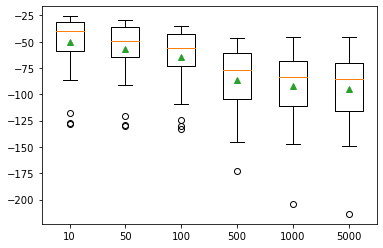

In [307]:
pyplot.boxplot(results_NT, labels=names_NT, showmeans=True)
pyplot.show()

Second for-loop for the tree depth

In [308]:
results_TD, names_TD = list(), list()

for name, model in models_TD.items():
    scores = evaluate_model(model)
    results_TD.append(scores)
    names_TD.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 -49.551 (28.282)
>2 -62.223 (27.056)
>3 -61.857 (27.516)
>4 -62.136 (27.418)
>5 -62.872 (27.011)
>6 -63.332 (27.094)
>7 -63.446 (27.458)
>8 -63.842 (27.300)
>9 -64.048 (27.276)
>10 -63.955 (27.187)


Plot model performance for comparison

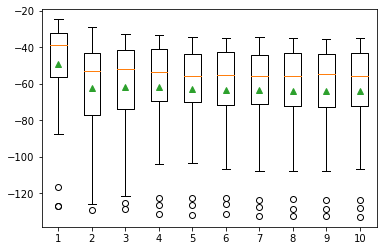

In [309]:
pyplot.boxplot(results_TD, labels=names_TD, showmeans=True)
pyplot.show()

Evaluate the models and store results

In [310]:
results_LR, names_LR = list(), list()
for name, model in models_LR.items():
    scores = evaluate_model(model)
    results_LR.append(scores)
    names_LR.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>0.0001 -49.240 (27.970)
>0.0010 -49.374 (27.989)
>0.0100 -50.497 (28.284)
>0.1000 -64.526 (27.380)
>1.0000 -99.217 (34.442)


Plot model performance for comparison

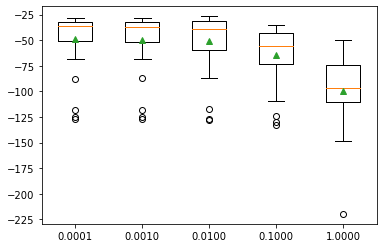

In [311]:
pyplot.boxplot(results_LR, labels=names_LR, showmeans=True)
pyplot.show()

Evaluate the models and store results

In [315]:
results_BT, names_BT = list(), list()
for name, model in models_BT.items():
    scores = evaluate_model(model)
    results_BT.append(scores)
    names_BT.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>gbdt -64.526 (27.380)
>dart -52.953 (28.306)
>goss -61.521 (27.199)


Plot model performance for comparison


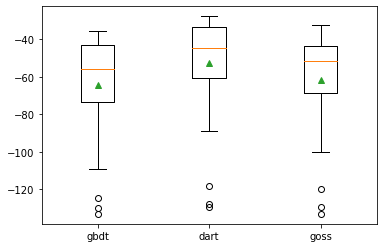

In [316]:
pyplot.boxplot(results_BT, labels=names_BT, showmeans=True)
pyplot.show()

# NOTES

- define new data
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
new_data = asarray([row])

- make a prediction
yhat = model.predict(new_data)

- summarize prediction
print('Predicted: %.3f' % yhat)

[LightGBM] [Warning] Unknown parameter: learnnig_rae
[1]	valid_0's l2: 5233.16	valid_0's l1: 23.437
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 5255.11	valid_0's l1: 23.5156
[3]	valid_0's l2: 5282.15	valid_0's l1: 23.7875
[4]	valid_0's l2: 5298.58	valid_0's l1: 23.8209
[5]	valid_0's l2: 5329.66	valid_0's l1: 24.0082
[6]	valid_0's l2: 5354.1	valid_0's l1: 24.169
[7]	valid_0's l2: 5366.1	valid_0's l1: 24.1856
[8]	valid_0's l2: 5400.87	valid_0's l1: 24.3395
[9]	valid_0's l2: 5404.82	valid_0's l1: 24.2013
[10]	valid_0's l2: 5413.52	valid_0's l1: 24.239
[11]	valid_0's l2: 5435.24	valid_0's l1: 24.2411
[12]	valid_0's l2: 5380.99	valid_0's l1: 24.2002
[13]	valid_0's l2: 5408.95	valid_0's l1: 24.3144
[14]	valid_0's l2: 5410.22	valid_0's l1: 24.319
[15]	valid_0's l2: 5441.53	valid_0's l1: 24.4735
[16]	valid_0's l2: 5436.29	valid_0's l1: 24.2616
[17]	valid_0's l2: 5485.66	valid_0's l1: 24.4787
[18]	valid_0's l2: 5479.35	valid_0's l1: 24.3949
[19]	valid_0's l2: 

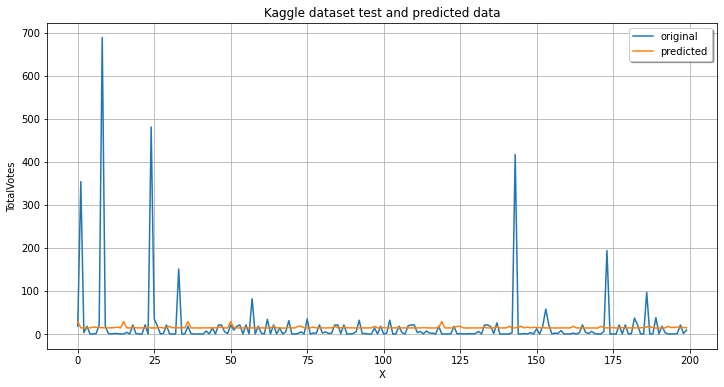

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

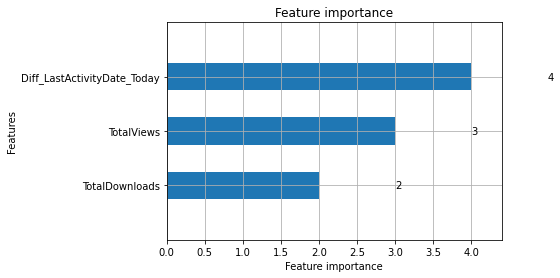

In [181]:
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import DataFrame

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rae': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

# laoding data
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

# prediction
y_pred = model.predict(x_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Kaggle dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('TotalVotes')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

# plotting feature importance
lgb.plot_importance(model, height=.5) 